Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [13]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

'\n*Uncomment if running on colab* \nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab \n'

# Import libs

In [14]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *
from models import dirichlet

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [15]:
# deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

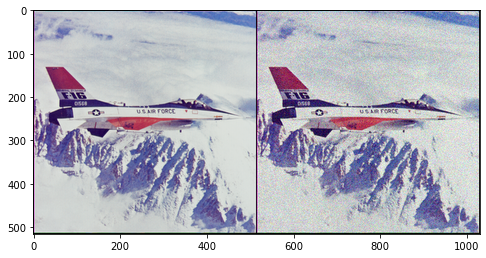

In [16]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)

    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5)
        
elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    M, N = img_pil.size
    img_np = pil_to_np(img_pil)
    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [17]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
# reg_noise_std = 0
LR = 0.005

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99
dirichlet_param_scalar = 10000

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [8, 16, 32, 64, 128], 
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 3000
    input_depth = 32 
    figsize = 4 
    
    
    net = get_net(input_depth, 'skip_dir', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)
dir_loss = dirichlet.DirichletLoss(M, N).type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

gt_distribution, sums = dirichlet.get_scaled_gt(img_noisy_torch, M, N)

Number of params: 2217831
True
True
True


# Optimize

Starting optimization with ADAM


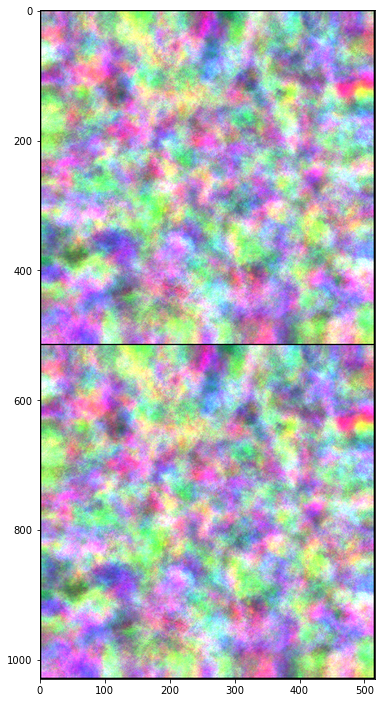

KeyboardInterrupt: 

In [18]:
# hyper-parameter to try
psi = 25 / 255.0
scaled_sigma = psi / sums

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
psrn_noisy_last = 0
psrn_gt_last = 0
prev_loss = None

i = 0
def closure():

    global i, out_avg, psrn_noisy_last, psrn_gt_last, net5, net4, net3, net2, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = dir_loss(out, (gt_distribution, scaled_sigma))
    total_loss.backward()


    out_recovered = dirichlet.recover_scale_torch(out, sums, M, N).detach().cpu().numpy()[0]
    out_avg_recovered = dirichlet.recover_scale_torch(out_avg, sums, M, N).detach().cpu().numpy()[0]
    psrn_noisy = compare_psnr(img_noisy_np,out_recovered)
    psrn_gt    = compare_psnr(img_np, out_recovered)
    psrn_gt_sm = compare_psnr(img_np, out_avg_recovered)

    print ('Iteration %05d    Loss %f PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        plot_image_grid([np.clip(out_recovered, 0, 1),
                         np.clip(out_avg_recovered, 0, 1)], factor=figsize, nrow=1)
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = dirichlet.recover_scale_torch(net(net_input), sums, M, N).detach().cpu().numpy()[0]
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);